#### EEA Summer School 2025: Measurement methods for sound field analysis, reconstruction and reproduction
**Exercise 1: Sound field reconstruction, wave expansions, and regularization.**

Sound field reconstruction consists on estimating an acoustic field over time and space from a limited number of observations. These observations could correspond to, for example, measurements captured with a microphone array or a distribution of sensors. 
Typically, in order to interpolate/extrapolate in between/away from the measured positions, we need to fit a model of the sound field to the observed data. Elementary wave expansions are some of the most common models using in sound field reconstruction.

In this notebook you will to learn to:
- Expand a sound field using elementary wave functions.
- Estimate the wave coefficients (i.e., their complex amplitudes).
- Regularize the problem to obtain a unique, stable solution and/or promote particular solutions.
- Reconstruct a sound field from limited observations.  

To solve the optimization problem we are going to use the package [`cvxpy`](https://www.cvxpy.org/index.html) for convex optimization. If you run this notebook in Colab you don´t need to install anything. 
If you are using Matlab, you can download and install the package [`cvx`](https://cvxr.com/cvx/doc/install.html). 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

We start by defining a couple of functions that compute simple sound fields. These will serve to synthesize the data necessary for the exercise.

- The function `Greens_free_field` computes the free-field Green's function between a receiver positioned at $\mathbf{r}$ and a source at $\mathbf{r}_0$:
$$
G(\mathbf{r},\mathbf{r}_0) = \frac{\text{e}^{\text{j} (\omega t - k R)}}{4 \pi R},
$$
where $R$ is the distance between source and receiver, $k$ is the wavenumber, $\omega$ is the angular frequency, and $t$ is the time. Note that we are considering harmonic sound fields and that we will drop the term $e^{j\omega t}$ for most of the calculations.

- The function `Greens_room` computes the Green's function in a 2D rectangular domain of dimensions $L_x, L_y$ with almost rigid boundaries. This could resemble the sound field inside a room at low frequencies:
$$
G(\mathbf{r},\mathbf{r}_0) = \frac{-1}{L_x L_y}\sum_{n} \frac{\Psi_n(\mathbf{r}) \Psi_n(\mathbf{r}_0)}{k^2 - k_n^2 - jk / (\tau c)} \text{e}^{\text{j} \omega  t},
$$
where $k_n = \sqrt{(\pi n_x / L_x)^2 + (\pi n_y / L_y)^2}$ is the wavenumber of mode $n=(n_x,n_y)$, $\tau$ is a time constant that controls the damping (assumed the same for all modes), and $\Psi_n$ are the mode shapes:
$$
\Psi_n(\mathbf{r}) = \cos(\pi n_x x / L_x) \cos(\pi n_y y / L_y).
$$

For simplicity, we will consider 2D simulations and wave expansions. 

In [18]:
def Greens_free_field(x, y, x0, y0, f, c):
    """Compute the 2D Green's function in free field."""
    """
    Parameters:
    x, y : np.ndarray
        Receiver coordinates.
    x0, y0 : float
        Source coordinates.
    f : float
        Frequency.
    c : float
        Speed of sound.
    Returns:
    G : np.ndarray
        The computed Green's function at the specified coordinates.
    """
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    k = 2 * np.pi * f / c
    G = np.exp(-1j * k * r) / (4 * np.pi * r)
    return G

def Greens_room(x, y, x0, y0, Lx, Ly, Nx, Ny, f, tau, c):
    """Compute the 2D Green's function in a lightly damped rectangular domain."""
    """
    Parameters:
    x, y : np.ndarray
        Receiver coordinates.
    x0, y0 : float
        Source coordinates.
    Lx, Ly : float
        Dimensions of the rectangular domain.
    Nx, Ny : int
        Number of modes in the x and y directions.
    f : float
        Frequency.
    tau : float
        Time constant (damping).
    c : float
        Speed of sound.
    Returns:
    G : np.ndarray
        The computed Green's function at the specified coordinates.
    """
    def mode_shapes(nx, ny, x, y):
        return np.cos(np.pi * nx * x / Lx) * np.cos(np.pi * ny * y / Ly)
    
    k = 2 * np.pi * f / c
    G = 0
    for nx in range(Nx):
        for ny in range(Ny):
            mode_xy = mode_shapes(nx, ny, x, y)
            mode_x0y0 = mode_shapes(nx, ny, x0, y0)
            k_n = np.sqrt((np.pi * nx / Lx)**2 + (np.pi * ny / Ly)**2)
            G += mode_xy * mode_x0y0 / (k**2 - k_n**2 - 1j*k / (tau * c))
    return -G/(Lx * Ly)



We define some parameters like the speed of sound, frequency of the sound field, dimensions of the room, number of modes, and damping. You are welcome to change and play around with these parameters.  

We then compute the resulting sound field on a fine grid. This will be the reference against which we will compare the reconstructed sound field. 

In [19]:
# Define parameters
c = 343 
f = 89.3
Lx, Ly = 5.0, 3.0  
Nx, Ny = 10, 10 
x0, y0 = 0.1, 0.1
tau = 0.5

# Compute the Green's function on a grid
X, Y = np.meshgrid(np.linspace(0, Lx, int(Lx*100)), np.linspace(0, Ly, int(Ly*100)))
r_rec = np.array([X.flatten(), Y.flatten()]).T
p_ref = Greens_room(r_rec[:, 0], r_rec[:, 1], x0, y0, Lx, Ly, Nx, Ny, f, tau, c)

**ex1.0**: 

In order to simulate measurements with a distribution of sensors, take `m = 15` random samples from the grid. We need both the positions `r` and the pressure at those positions `p`.
An easy way of doing this is sampling some indices using 

`indices = np.random.choice(p_ref.size, m, replace=False)`

and then getting the positions and pressure values for those indices. 

**ex1.1**: 

When dealing with measured data, there will always be noise. Therefore, we need to add noise to the observations. To get `m` random numbers from a standard normal distribution you can use 

`np.random.randn(m)`

Remember that since we are working in the frequency domain, the pressure is complex, so you need to add complex-valued noise. Scale the noise to obtain a "reasonable" signal-to-noise ratio (e.g. 20 dB).


In [20]:
# Here comes your code:

In [21]:
# Solution:
# Take samples randomly and add noise
np.random.seed(42)
m = 15
indices = np.random.choice(p_ref.size, m, replace=False)
p = p_ref[indices]
p += 0.1 * (np.random.randn(m) + 1j * np.random.randn(m)) * np.sqrt(np.mean(np.abs(p)**2))
r = r_rec[indices]

The following cell plots a figure of the reference and sampled locations to check what we have done so far. 

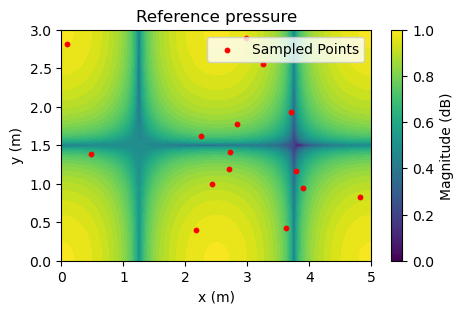

In [22]:
# Figure of the reference pressure over space and the sampled points
plt.figure(figsize=(5, 3))
plt.contourf(X, Y, 20*np.log10(np.abs(p_ref)).reshape(X.shape), levels=50, cmap='viridis')
plt.scatter(r[:, 0], r[:, 1], c='red', s=10, label='Sampled Points')
plt.legend(loc='upper right')
plt.colorbar(label='Magnitude (dB)')
plt.title('Reference pressure')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

**Plane wave expansion.**

Among the most common models in sound field reconstruction are plane wave expansions, in which the sound field is expressed as the sum of a finite number of propagating plane waves,

$$
p(\mathbf{r}, t) = \sum_{i=0}^{n-1} x_i \text{e}^{\text{j} (\omega t - \mathbf{k}_i \cdot \mathbf{r})}
$$

where $n$ is the number of plane waves in the expansion, and $x_i$ is the coefficient of the $i^\text{th}$ wave. These coefficients are complex numbers that encapsulate the amplitude and phase of each wave. We don't know the $x_i\text{s}$ in principle, and they are precisely what we want to estimate from the measurements. Once these coefficients are estimated, it is possible to approximate the sound field at any position (more on that later).

The exponential term $\text{e}^{-\text{j} \mathbf{k}_i \cdot \mathbf{r}}$ accounts for the wave propagation, which is just a phase shift since we are considering plane waves. The term $\mathbf{k}_i$ is the wavenumber vector of the $i^\text{th}$ wave. For propagating plane waves, this vector points in the direction of propagation, i.e., $\mathbf{k}_i = k(\cos(\theta_i), \sin(\theta_i))$, with $k= 2 \pi f / c$. It is up to us to define the wave directions. Typically, the angles $\theta_i$ are uniformly sampled on the unit circle (in 2D) or on the unit sphere (in 3D).

Here we consider that the sound field is composed only of propagating plane waves. This is a valid assumption far from sound sources, but a "full" solution would also include evanescent waves [Williams1999].

Since we have multiple measurements, it is convenient to express the wave expansion algebraically,

$$
\mathbf{p} = \mathbf{A} \mathbf{x} + \mathbf{n},
$$

where $\mathbf{p}\in \mathbb{C}^m$ contains the pressure at the measurement positions, $\mathbf{A} \in \mathbb{C}^{m\times n}$ is a matrix whose elements are the complex exponentials $a_{i,j} = \text{e}^{-\text{j} \mathbf{k}_i \cdot \mathbf{r}_j}$, $\mathbf{x}\in \mathbb{C}^n$ contains the unknown wave coefficients, and $\mathbf{n}\in \mathbb{C}^m$ is a noise term. Note that this noise term combines both the measurments noise and a possible discrepancy between the actual sound field and the plane wave model.

**ex1.2**:

Create a plane wave expansion matrix.
- Get the angles `thetas` by dividing the unit circle into `n = 360` directions.
- Compute the wavenumber vector for each direction. You will get an array `k` of size `(n,2)`.
- Compute the plane wave expansion matrix `A` using the wavenumber vectors `k` and the measurement positions `r`.

In [23]:
# Here comes your code:

In [24]:
# Plane wave expansion
n = 360
thetas = np.linspace(0, 2 * np.pi, n)
k  = (2 * np.pi * f / c) * np.array([np.cos(thetas), np.sin(thetas)]).T
A = np.exp(-1j * k @ r.T).T

**Optimization problem.**

The previous expression, $\mathbf{p} = \mathbf{A} \mathbf{x} + \mathbf{n}$, is a linear system of equations with $n$ unknowns (one for each wave coefficient in the expansion) and $m$ equations (one for each sensor in the array). The goal is to estimate $\mathbf{x}$ from the measurements $\mathbf{p}$. However, this is most likely an ill-posed problem because:
- We only have access to a limited number of measurements. Typical microphone arrays have, at most, a few tens of microphones, and practically deploying hundreds of sensors over space is impractical and costly. Therefore, the number of unknowns is likely larger than the number of equations, and there can be infinitely many solutions to the system of equations.

- The matrix $\mathbf{A}$ is ill-conditioned. That means that some of its rows or columns are linearly dependent. Linear dependency of the rows can be avoided by distributing the sensors over space. However, the column linear dependency comes from the plane wave expansion model, and there is not much we can do about it. An ill-conditioned $\mathbf{A}$ makes the solutions extremely sensitive to small perturbations in the input data, like noise, leading to erroneous estimations [Hansen1998].

A naive way of solving this problem would be the least-squares solution

$$
\tilde{\mathbf{x}}_\text{ls} = \arg \min_{\mathbf{x}\in \mathbb{C}^n} \| \mathbf{A} \mathbf{x} - \mathbf{p} \|^2_2
$$

The solution $\tilde{\mathbf{x}}_\text{ls}$ is the one that minimizes the Euclidean distance between measurements and fitted model. Even if it simple, this solution will fail is $\mathbf{A}$ is ill-conditioned, since the noise will be largely amplified. You can check the conditionining of $\mathbf{A}$ by computing its condition number, i.e. the ratio between the largest and smallest singular values. A large condition number indicates that the problem is very sensitive to small perturbations in the data. 

In [25]:
cond_A = np.linalg.cond(A)
print(f"Condition number of A: {cond_A:.2e}")

Condition number of A: 8.04e+05


**Regularization.**

Regularization is a strategy to solve ill-posed problems, which consists on including additional constraints to arrive to a unique, stable solution. 

- **$\ell_2$ regularization**

Arguably the most common regularization is the $\ell_2$ regularization, also known as Tikhonov regularization or ridge regression. This regularization aims at finding the solution that both fits the data and has minimum energy

$$
\tilde{\mathbf{x}}_\text{l2} = \arg \min_{\mathbf{x}\in \mathbb{C}^n} \| \mathbf{A} \mathbf{x} - \mathbf{p} \|^2_2 + \alpha \| \mathbf{x} \|^2_2
$$

You can see that the first term is similar than for the least-squares solution, but we add a second term that penalizes large $\| \mathbf{x} \|^2_2$. In this way, we control the energy of the solution so that it doesn't "explode" due to the ill-conditioning. The parameter $\alpha$ controls the relative weight of the two terms. There are many different ways of choosing $\alpha$ automatically (L-curve criterion, generalized cross validation, discrepancy principle, etc.) but to keep it simple we will just choose manually. 

The $\ell_2$ regularization is simple, efficient, and well undestood. It can be shown that applying this regularization has a low-pass filter effect in the solution, and therefore the estimated coefficients $\tilde{\mathbf{x}}_\text{l2}$ tend to be smooth, with many coefficients that are non-zero. The $\ell_2$ regularization effectively filters out the noise, but sometimes a smooth solution is not desireable, for example, if we know beforehnad that the sound field can be expressed by just a few plane waves (but not which ones). 

- **$\ell_1$ regularization**

A more recent but popular regularization is the $\ell_1$ regularization, also known as compressive sensing or lasso regression. In this case, the regularization aims at finding the solution that fits the data and has minimum $\ell_1$ norm. 

$$
\tilde{\mathbf{x}}_\text{l1} = \arg \min_{\mathbf{x}\in \mathbb{C}^n} \| \mathbf{A} \mathbf{x} - \mathbf{p} \|^2_2 + \alpha \| \mathbf{x} \|_1
$$

where the $\ell_1$ norm is the sum of the magnitudes of the vector elements

$$
\| \mathbf{x} \|_1 = \sum_{i=0}^n |x_i|.
$$

It can be shown that the $\ell_1$ regularization promotes sparse solutions, i.e., solutions with a small number of non-zero entries. This is  

In [26]:
# Solve problem
alpha_l1 = 1
alpha_l2 = 1

x_ls = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_ls - p)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

x_l2 = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_l2 - p) + alpha_l2*cp.norm(x_l2, 2)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

x_l1 = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_l1 - p) + alpha_l1*cp.norm(x_l1, 1)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

x_en = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_en - p) + alpha_l1*cp.norm(x_en, 1) + alpha_l2*cp.norm(x_en, 2)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()


np.float64(8.948440081958207)

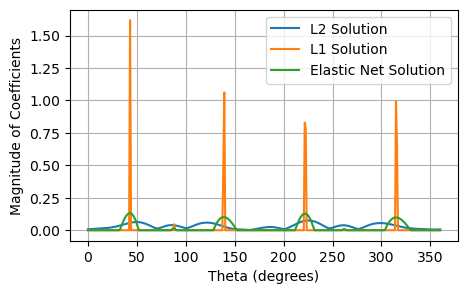

In [27]:
plt.figure(figsize=(5, 3))
# plt.plot(thetas * 180 / np.pi, np.abs(x_ls.value), label='LS Solution')
plt.plot(thetas * 180 / np.pi, np.abs(x_l2.value), label='L2 Solution')
plt.plot(thetas * 180 / np.pi, np.abs(x_l1.value), label='L1 Solution')
plt.plot(thetas * 180 / np.pi, np.abs(x_en.value), label='Elastic Net Solution')
plt.xlabel('Theta (degrees)')
plt.ylabel('Magnitude of Coefficients')
plt.legend()
plt.grid()
plt.show()

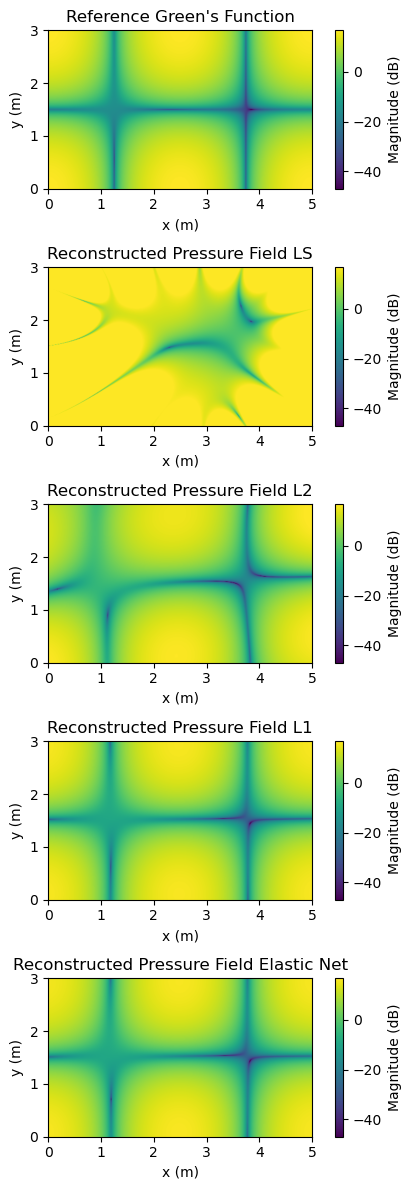

In [28]:
r_rec = np.array([X.flatten(), Y.flatten()]).T
B = np.exp(-1j * k @ r_rec.T).T

fig, axes = plt.subplots(5, 1, figsize=(5, 12))

# Compute the min and max values in dB for consistent colorbars
ref_db = 20 * np.log10(np.abs(p_ref))
rec_ls_db = 20 * np.log10(np.abs(p_rec_ls := B @ x_ls.value))
rec_l2_db = 20 * np.log10(np.abs(p_rec_l2 := B @ x_l2.value))
rec_l1_db = 20 * np.log10(np.abs(p_rec_l1 := B @ x_l1.value))
rec_en_db = 20 * np.log10(np.abs(p_rec_en := B @ x_en.value))
vmin, vmax = min(ref_db), max(ref_db)

# Reference Green's Function
im0 = axes[0].imshow(ref_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[0].set_title("Reference Green's Function")
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
fig.colorbar(im0, ax=axes[0], label='Magnitude (dB)')

# Reconstructed Pressure Field LS
im1 = axes[1].imshow(rec_ls_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[1].set_title('Reconstructed Pressure Field LS')
axes[1].set_xlabel('x (m)')
axes[1].set_ylabel('y (m)')
fig.colorbar(im1, ax=axes[1], label='Magnitude (dB)')

# Reconstructed Pressure Field L2
im2 = axes[2].imshow(rec_l2_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[2].set_title('Reconstructed Pressure Field L2')
axes[2].set_xlabel('x (m)')
axes[2].set_ylabel('y (m)')
fig.colorbar(im2, ax=axes[2], label='Magnitude (dB)')

# Reconstructed Pressure Field L1
im3 = axes[3].imshow(rec_l1_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[3].set_title('Reconstructed Pressure Field L1')
axes[3].set_xlabel('x (m)')
axes[3].set_ylabel('y (m)')
fig.colorbar(im3, ax=axes[3], label='Magnitude (dB)')

# Reconstructed Pressure Field Elastic Net
im4 = axes[4].imshow(rec_en_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[4].set_title('Reconstructed Pressure Field Elastic Net')
axes[4].set_xlabel('x (m)')
axes[4].set_ylabel('y (m)')
fig.colorbar(im4, ax=axes[4], label='Magnitude (dB)')

plt.tight_layout()
plt.show()


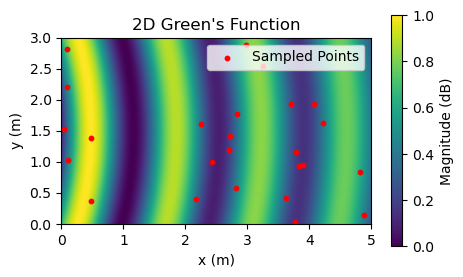

In [29]:
# Define parameters
c = 343 
f = 250
Lx, Ly = 5.0, 3.0  
Nx, Ny = 10, 10 
x0, y0 = -5, 1.5
tau = 0.5

# Compute the Green's function on a grid
X, Y = np.meshgrid(np.linspace(0, Lx, int(Lx*100)), np.linspace(0, Ly, int(Ly*100)))
r_rec = np.array([X.flatten(), Y.flatten()]).T
p_ref = Greens_free_field(r_rec[:, 0], r_rec[:, 1], x0, y0, f, c)

# Take samples randomly and add noise
np.random.seed(42)
m = 25
indices = np.random.choice(p_ref.size, m, replace=False)
p = p_ref[indices]
p += 0.01 * (np.random.randn(m) + 1j * np.random.randn(m)) * np.sqrt(np.mean(np.abs(p)**2))
r = r_rec[indices]

# Make a figure of the Green's function over space
plt.figure(figsize=(5, 3))
plt.imshow(np.real(p_ref).reshape(X.shape), cmap='viridis', extent=(0, Lx, 0, Ly))
plt.scatter(r[:, 0], r[:, 1], c='red', s=10, label='Sampled Points')
plt.legend(loc='upper right')
plt.colorbar(label='Magnitude (dB)')
plt.title('2D Green\'s Function')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

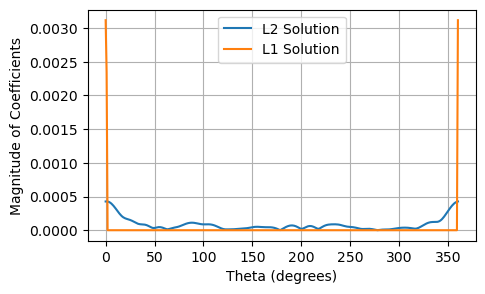

In [30]:
# Plane wave expansion
n = 360
theta = np.linspace(0, 2 * np.pi, n)
k  = (2 * np.pi * f / c) * np.array([np.cos(theta), np.sin(theta)]).T
A = np.exp(-1j * k @ r.T).T

# Solve problem
alpha = 0.1

x_ls = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_ls - p)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

x_l2 = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_l2 - p) + alpha*cp.norm(x_l2, 2)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

x_l1 = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_l1 - p) + alpha*cp.norm(x_l1, 1)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

plt.figure(figsize=(5, 3))
# plt.plot(theta * 180 / np.pi, np.abs(x_ls.value), label='LS Solution')
plt.plot(theta * 180 / np.pi, np.abs(x_l2.value), label='L2 Solution')
plt.plot(theta * 180 / np.pi, np.abs(x_l1.value), label='L1 Solution')
plt.xlabel('Theta (degrees)')
plt.ylabel('Magnitude of Coefficients')
plt.legend()
plt.grid()
plt.show()

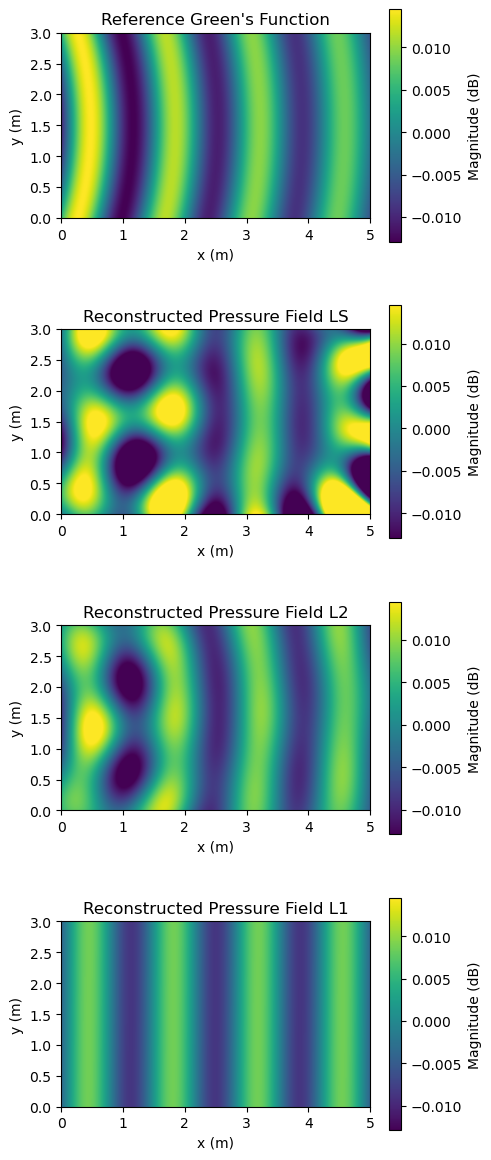

In [31]:
r_rec = np.array([X.flatten(), Y.flatten()]).T
B = np.exp(-1j * k @ r_rec.T).T

fig, axes = plt.subplots(4, 1, figsize=(5, 12))

# Compute the min and max values in dB for consistent colorbars
ref_db = p_ref.real
rec_ls_db = B @ x_ls.value
rec_l2_db = B @ x_l2.value
rec_l1_db =B @ x_l1.value
rec_ls_db = rec_ls_db.real
rec_l2_db = rec_l2_db.real
rec_l1_db = rec_l1_db.real
vmin, vmax = min(ref_db), max(ref_db)

# Reference Green's Function
im0 = axes[0].imshow(ref_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[0].set_title("Reference Green's Function")
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
fig.colorbar(im0, ax=axes[0], label='Magnitude (dB)')

# Reconstructed Pressure Field LS
im1 = axes[1].imshow(rec_ls_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[1].set_title('Reconstructed Pressure Field LS')
axes[1].set_xlabel('x (m)')
axes[1].set_ylabel('y (m)')
fig.colorbar(im1, ax=axes[1], label='Magnitude (dB)')

# Reconstructed Pressure Field L2
im2 = axes[2].imshow(rec_l2_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[2].set_title('Reconstructed Pressure Field L2')
axes[2].set_xlabel('x (m)')
axes[2].set_ylabel('y (m)')
fig.colorbar(im2, ax=axes[2], label='Magnitude (dB)')

# Reconstructed Pressure Field L1
im3 = axes[3].imshow(rec_l1_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[3].set_title('Reconstructed Pressure Field L1')
axes[3].set_xlabel('x (m)')
axes[3].set_ylabel('y (m)')
fig.colorbar(im3, ax=axes[3], label='Magnitude (dB)')

plt.tight_layout()
plt.show()


Make a expansion with point sources. 
Change the code to do it 3D. 
Make an animation.
Create different arrays/distributions 

**References**
- [Willians1999]
- [Hansen1998]
